# Mammographic Mass: Exploratory Data Analysis
 
### 1. Introduction and Setup
 
This notebook presents a Exploratory Data Analysis (EDA) of the Mammographic Mass dataset from the UCI Machine Learning Repository. The primary objective is to understand the characteristics that distinguish benign from malignant mammographic masses, assess data quality, and identify key predictive features for computer-aided diagnosis (CAD) systems.

The dataset contains 961 mammographic mass cases with BI-RADS attributes and patient demographics. The target variable is `Severity`, classified as benign (0) or malignant (1). This analysis aims to reduce unnecessary biopsies by identifying patterns that can improve diagnostic accuracy.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 

COLOR_PALETTE = 'rocket_r' 
sns.set_style("whitegrid")
COLORS_BINARY = sns.color_palette(COLOR_PALETTE, 2) 
plt.rcParams['figure.figsize'] = (12, 6)

mammographic_mass = fetch_ucirepo(id=161)

X = mammographic_mass.data.features
y = mammographic_mass.data.targets

df = pd.concat([X, y], axis=1)

print("Dataset loaded successfully using ucimlrepo!")
print(f"Dataset shape: {df.shape}")
print(df.head(10))


Dataset loaded successfully using ucimlrepo!
Dataset shape: (961, 6)
   BI-RADS   Age  Shape  Margin  Density  Severity
0      5.0  67.0    3.0     5.0      3.0         1
1      4.0  43.0    1.0     1.0      NaN         1
2      5.0  58.0    4.0     5.0      3.0         1
3      4.0  28.0    1.0     1.0      3.0         0
4      5.0  74.0    1.0     5.0      NaN         1
5      4.0  65.0    1.0     NaN      3.0         0
6      4.0  70.0    NaN     NaN      3.0         0
7      5.0  42.0    1.0     NaN      3.0         0
8      5.0  57.0    1.0     5.0      3.0         1
9      5.0  60.0    NaN     5.0      1.0         1


### 2. Data Quality Assessment and Cleaning
 
#### Initial Data Inspection
 
Let's examine the structure, types, and completeness of our dataset.


In [2]:
print(df.describe())

          BI-RADS         Age       Shape      Margin     Density    Severity
count  959.000000  956.000000  930.000000  913.000000  885.000000  961.000000
mean     4.348279   55.487448    2.721505    2.796276    2.910734    0.463059
std      1.783031   14.480131    1.242792    1.566546    0.380444    0.498893
min      0.000000   18.000000    1.000000    1.000000    1.000000    0.000000
25%      4.000000   45.000000    2.000000    1.000000    3.000000    0.000000
50%      4.000000   57.000000    3.000000    3.000000    3.000000    0.000000
75%      5.000000   66.000000    4.000000    4.000000    3.000000    1.000000
max     55.000000   96.000000    4.000000    5.000000    4.000000    1.000000


In [3]:
missing_stats = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})

print("\n")
print("MISSING VALUES ANALYSIS")
print("\n")
print(missing_stats.to_string(index=False))



MISSING VALUES ANALYSIS


 Feature  Missing_Count  Missing_Percentage Data_Type
 BI-RADS              2                0.21   float64
     Age              5                0.52   float64
   Shape             31                3.23   float64
  Margin             48                4.99   float64
 Density             76                7.91   float64
Severity              0                0.00     int64


#### Missing Data Patterns
 
The dataset has some missing values across multiple features:
- **BI-RADS**: 2 missing (0.21%)
- **Age**: 5 missing (0.52%)
- **Shape**: 31 missing (3.22%)
- **Margin**: 48 missing (4.99%)
- **Density**: 76 missing (7.91%) - highest missingness
- **Severity**: 0 missing (target variable is complete)

We need to investigate whether missing values are random or systematic.

In [4]:
severity_map = {0: 'Benign', 1: 'Malignant'}

df['Severity_Label'] = df['Severity'].map(severity_map)

for col in ['Age', 'Shape', 'Margin', 'Density']:
    missing_by_severity = df.groupby('Severity_Label')[col].apply(lambda x: x.isnull().sum())
    print(f"\n{col} missing values by Severity:")
    print(missing_by_severity)


Age missing values by Severity:
Severity_Label
Benign       0
Malignant    5
Name: Age, dtype: int64

Shape missing values by Severity:
Severity_Label
Benign       19
Malignant    12
Name: Shape, dtype: int64

Margin missing values by Severity:
Severity_Label
Benign       37
Malignant    11
Name: Margin, dtype: int64

Density missing values by Severity:
Severity_Label
Benign       54
Malignant    22
Name: Density, dtype: int64


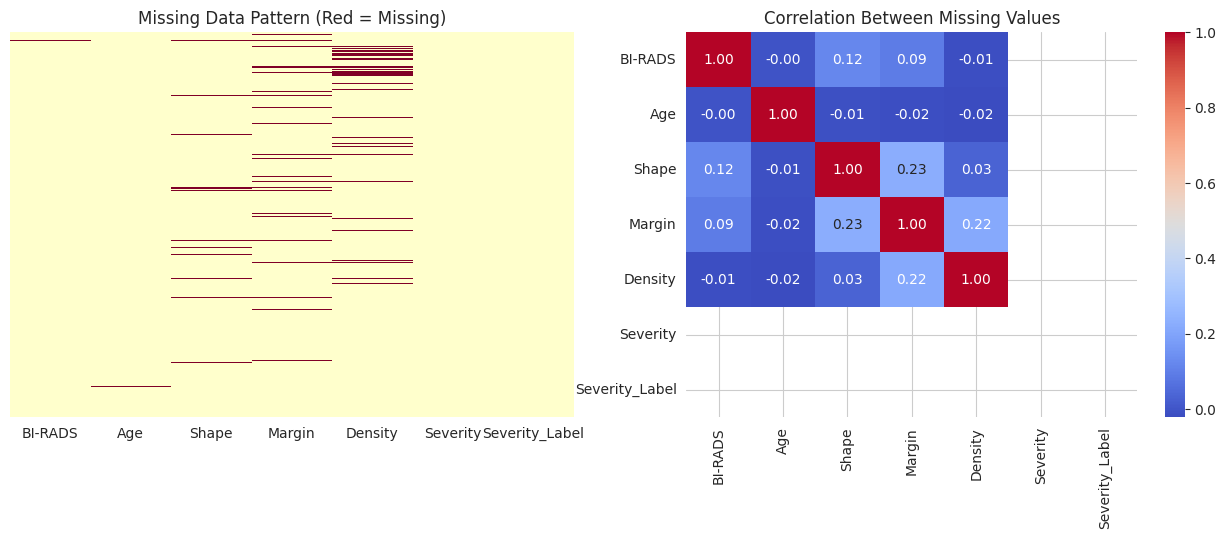

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

missing_mask = df.isnull()
sns.heatmap(missing_mask, cbar=False, yticklabels=False, cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Missing Data Pattern (Red = Missing)')

missing_corr = missing_mask.corr()
sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Between Missing Values')

plt.show()

* **Extent**: Missing values are present in all features except the target, `Severity`. **Density** has the most missing data (7.91%). Overall, **13.6%** of records are incomplete.
* **Pattern**: Missingness is correlated, particularly between `Margin`, `Shape`, and `Density`, indicating that values for these features are often missing together for the same case.

The data is **not missing completely at random (MCAR)**. Its presence is strongly correlated with the `Severity` target variable:

* Missingness in `Shape`, `Margin`, and `Density` is far more common in **benign** cases.
* Conversely, all 5 missing `Age` values are in **malignant** cases.
* As a result, incomplete records are much more likely to be benign (**67.9%**) than complete records (**51.5%**).

Because of that, we should **Avoid listwise deletion and simple imputation** (mean/median). These methods will introduce significant bias by disproportionately removing benign cases and ignoring the non-random nature of the data.

Let's use Multivariate Imputation by Chained Equations (MICE) to impute our missing values.

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

imputer = IterativeImputer(max_iter=10, random_state=0)

df_imputed = df.copy()
cols_to_impute = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']

print("Starting MICE imputation...")
df_imputed[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])
print("Imputation complete.")

# The imputer produces floats that may be out of range so we clip them to their valid clinical ranges.
df_imputed['BI-RADS'] = np.clip(df_imputed['BI-RADS'], 1, 5)
df_imputed['Shape'] = np.clip(df_imputed['Shape'], 1, 4)
df_imputed['Margin'] = np.clip(df_imputed['Margin'], 1, 5)
df_imputed['Density'] = np.clip(df_imputed['Density'], 1, 4)

df_imputed[cols_to_impute] = df_imputed[cols_to_impute].round().astype(int)

print("\nMissing values AFTER MICE and Clipping:")
print(df_imputed[cols_to_impute].isnull().sum())
print("\nUnique BI-RADS values:", sorted(df_imputed['BI-RADS'].unique()))

df = df_imputed.copy()
print("\nDataFrame is updated and ready for plotting.")
df.head()


Starting MICE imputation...
Imputation complete.

Missing values AFTER MICE and Clipping:
BI-RADS    0
Age        0
Shape      0
Margin     0
Density    0
dtype: int64

Unique BI-RADS values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

DataFrame is updated and ready for plotting.


,BI-RADS,Age,Shape,Margin,Density,Severity,Severity_Label
0,5,67,3,5,3,1,Malignant
1,4,43,1,1,3,1,Malignant
2,5,58,4,5,3,1,Malignant
3,4,28,1,1,3,0,Benign
4,5,74,1,5,3,1,Malignant


In [7]:
print(f"\nMissing values remaining: {df_imputed.isnull().sum().sum()}")

df_imputed['BI-RADS'] = df_imputed['BI-RADS'].astype(int)
df_imputed['Age'] = df_imputed['Age'].astype(int)
df_imputed['Shape'] = df_imputed['Shape'].astype(int)
df_imputed['Margin'] = df_imputed['Margin'].astype(int)
df_imputed['Density'] = df_imputed['Density'].astype(int)
df_imputed['Severity'] = df_imputed['Severity'].astype(int)

df = df_imputed.copy()
df.head()



Missing values remaining: 0


,BI-RADS,Age,Shape,Margin,Density,Severity,Severity_Label
0,5,67,3,5,3,1,Malignant
1,4,43,1,1,3,1,Malignant
2,5,58,4,5,3,1,Malignant
3,4,28,1,1,3,0,Benign
4,5,74,1,5,3,1,Malignant


#### Outlier Detection
 
Medical data can contain extreme values that are either measurement errors or genuine rare cases. Let's investigate potential outliers.


In [8]:
print(df['Age'].describe())
print(f"\nAge range: {df['Age'].min()} - {df['Age'].max()} years")

age_outliers = df[(df['Age'] < 18) | (df['Age'] > 95)]
print(f"\nPotential age outliers (< 18 or > 95): {len(age_outliers)}")

count    961.000000
mean      55.511967
std       14.447466
min       18.000000
25%       45.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: Age, dtype: float64

Age range: 18 - 96 years

Potential age outliers (< 18 or > 95): 1


/tmp/ipykernel_104889/1183549025.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Benign', 'Malignant'])


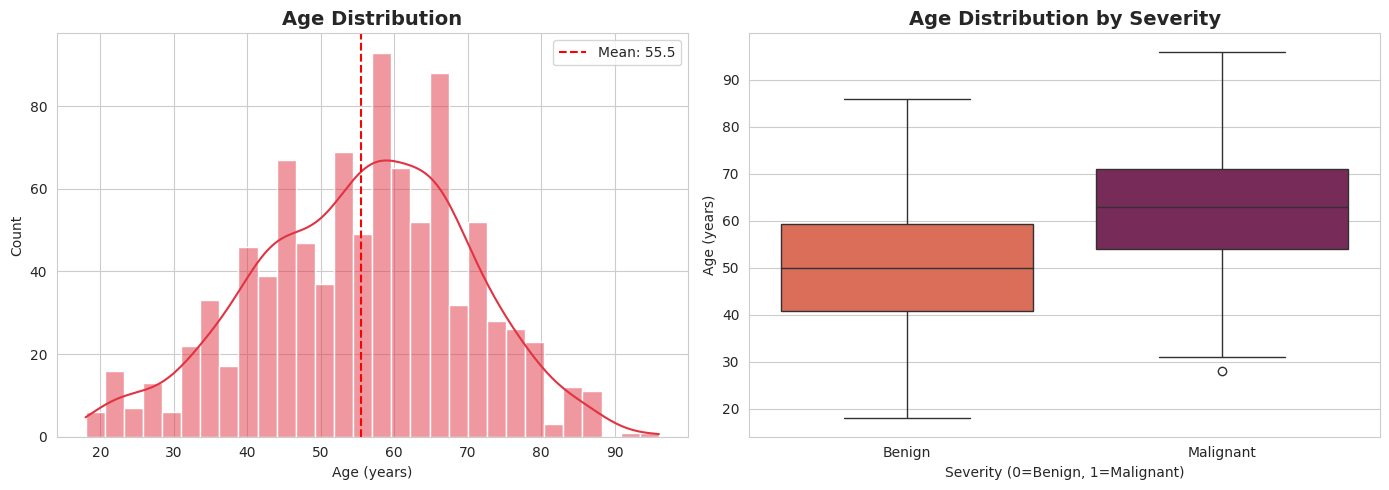

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=df, x='Age', bins=30, kde=True, ax=axes[0], color=sns.color_palette(COLOR_PALETTE)[2])
axes[0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Count')
axes[0].axvline(df['Age'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["Age"].mean():.1f}')
axes[0].legend()

sns.boxplot(data=df, x='Severity', y='Age', ax=axes[1], 
            palette=COLOR_PALETTE, hue='Severity', legend=False)
axes[1].set_title('Age Distribution by Severity', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Severity (0=Benign, 1=Malignant)')
axes[1].set_ylabel('Age (years)')
axes[1].set_xticklabels(['Benign', 'Malignant'])

plt.tight_layout()
plt.show()


Patients with malignant masses are generally older than those with benign masses, with a mean age of 55.5 across the entire dataset. 

The box plot highlights this distinction and identifies one outlier: a patient with a malignant diagnosis who is unusually young (under 30). This data point, while statistically rare, is clinically plausible and represents a critical edge case.

Given the short number of outliers, we wont need to remove them/normalize the data.

### 3. Exploratory Data Analysis

With clean data, we can now explore the relationships between features and mammographic mass severity.
 
#### Target Variable: Severity Distribution

Understanding the class balance is crucial for both interpretation and modeling strategy.

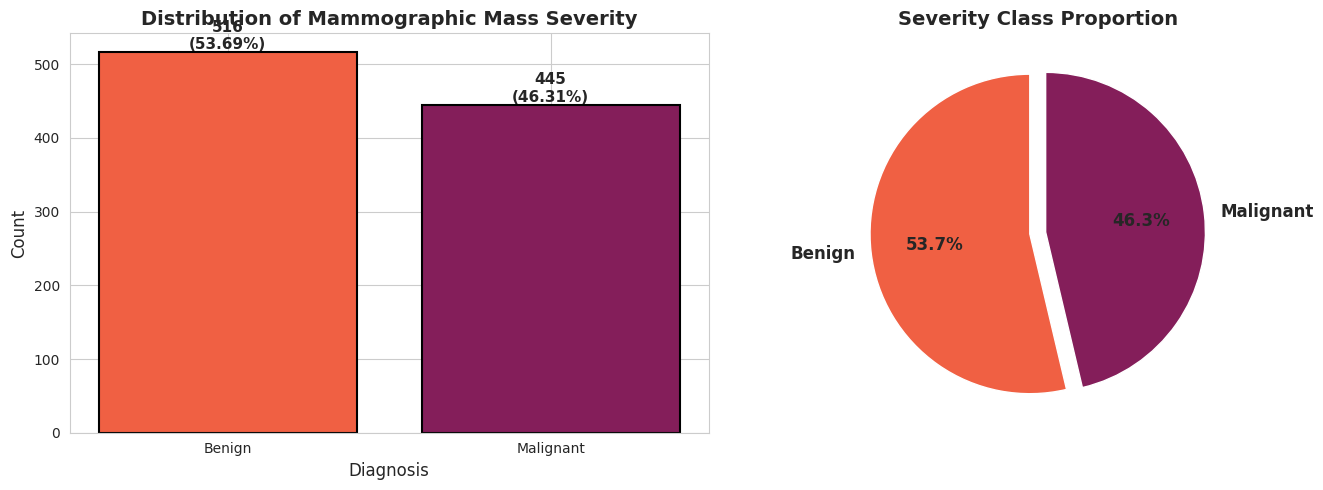

SEVERITY CLASS DISTRIBUTION: 
Benign (0): 516 cases (53.69%)
Malignant (1): 445 cases (46.31%)

Class ratio (Benign:Malignant): 1.16:1


In [10]:

severity_counts = df['Severity'].value_counts().sort_index()
severity_pct = (severity_counts / len(df) * 100).round(2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
bars = ax1.bar(['Benign', 'Malignant'], severity_counts.values, 
               color=COLORS_BINARY, edgecolor='black', linewidth=1.5)
ax1.set_title('Distribution of Mammographic Mass Severity', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Diagnosis', fontsize=12)

for i, (bar, count, pct) in enumerate(zip(bars, severity_counts.values, severity_pct.values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({pct}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

colors_pie = COLORS_BINARY
explode = (0.05, 0.05)
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(severity_counts.values, 
                                     labels=['Benign', 'Malignant'],
                                     autopct='%1.1f%%',
                                     colors=colors_pie,
                                     explode=explode,
                                     startangle=90,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Severity Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("SEVERITY CLASS DISTRIBUTION: ")
print(f"Benign (0): {severity_counts[0]} cases ({severity_pct[0]}%)")
print(f"Malignant (1): {severity_counts[1]} cases ({severity_pct[1]}%)")
print(f"\nClass ratio (Benign:Malignant): {severity_counts[0]/severity_counts[1]:.2f}:1")



As seen in the chart, the target variable, `Severity`, has a well-balanced class distribution. 

#### Feature Value Distributions
 
Let's examine the distribution of each feature to understand their ranges and characteristics.


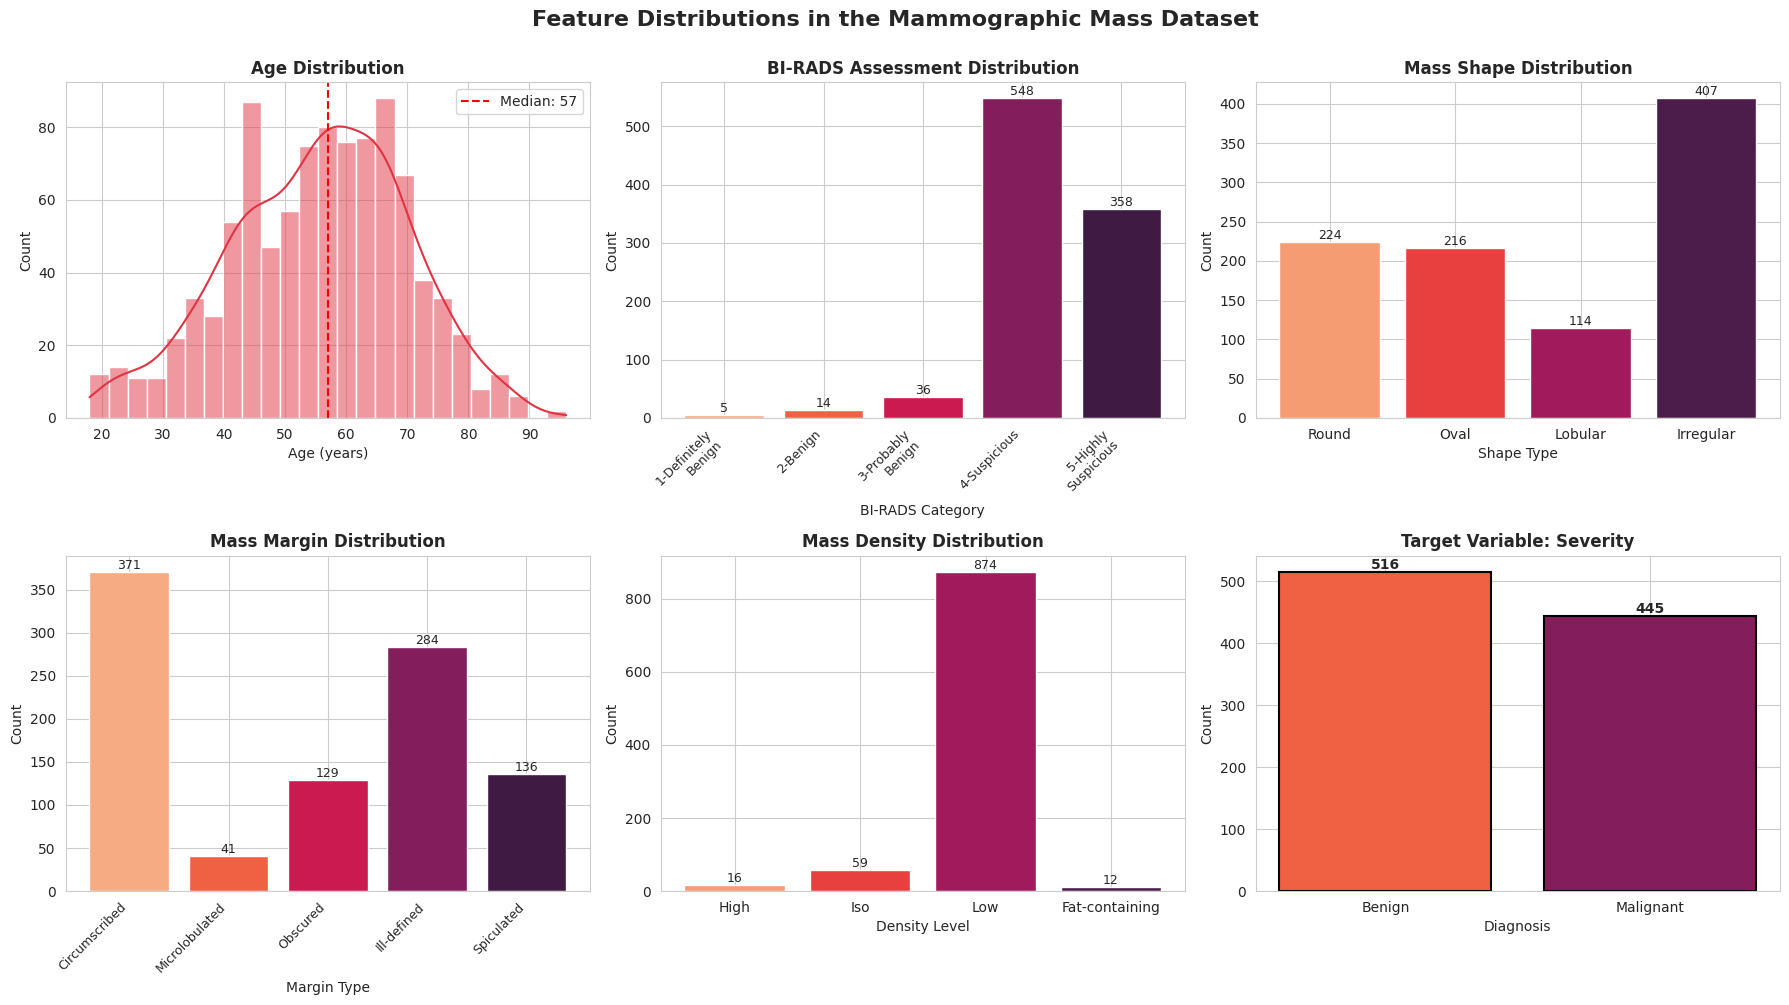

In [11]:
feature_labels = {
    'BI-RADS': {1: '1-Definitely\nBenign', 2: '2-Benign', 3: '3-Probably\nBenign', 
                4: '4-Suspicious', 5: '5-Highly\nSuspicious'},
    'Shape': {1: 'Round', 2: 'Oval', 3: 'Lobular', 4: 'Irregular'},
    'Margin': {1: 'Circumscribed', 2: 'Microlobulated', 3: 'Obscured', 
               4: 'Ill-defined', 5: 'Spiculated'},
    'Density': {1: 'High', 2: 'Iso', 3: 'Low', 4: 'Fat-containing'}
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions in the Mammographic Mass Dataset', 
             fontsize=16, fontweight='bold', y=1.00)

# Age (continuous)
ax = axes[0, 0]
sns.histplot(data=df, x='Age', bins=25, kde=True, ax=ax, color=sns.color_palette(COLOR_PALETTE)[2])
ax.set_title('Age Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Age (years)')
ax.axvline(df['Age'].median(), color='red', linestyle='--', 
           label=f'Median: {df["Age"].median():.0f}')
ax.legend()

# BI-RADS (ordinal)
ax = axes[0, 1]
birads_counts = df['BI-RADS'].value_counts().sort_index()
bars = ax.bar(range(len(birads_counts)), birads_counts.values, 
              color=sns.color_palette(COLOR_PALETTE, n_colors=5))
ax.set_title('BI-RADS Assessment Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('BI-RADS Category')
ax.set_ylabel('Count')
ax.set_xticks(range(len(birads_counts)))
ax.set_xticklabels([feature_labels['BI-RADS'][i] for i in birads_counts.index], 
                   rotation=45, ha='right', fontsize=9)
for i, (bar, val) in enumerate(zip(bars, birads_counts.values)):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=9)

# Shape (nominal)
ax = axes[0, 2]
shape_counts = df['Shape'].value_counts().sort_index()
bars = ax.bar(range(len(shape_counts)), shape_counts.values, 
              color=sns.color_palette(COLOR_PALETTE, n_colors=4))
ax.set_title('Mass Shape Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Shape Type')
ax.set_ylabel('Count')
ax.set_xticks(range(len(shape_counts)))
ax.set_xticklabels([feature_labels['Shape'][i] for i in shape_counts.index])
for bar, val in zip(bars, shape_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=9)

# Margin (nominal)
ax = axes[1, 0]
margin_counts = df['Margin'].value_counts().sort_index()
bars = ax.bar(range(len(margin_counts)), margin_counts.values, 
              color=sns.color_palette(COLOR_PALETTE, n_colors=5))
ax.set_title('Mass Margin Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Margin Type')
ax.set_ylabel('Count')
ax.set_xticks(range(len(margin_counts)))
ax.set_xticklabels([feature_labels['Margin'][i] for i in margin_counts.index], 
                   rotation=45, ha='right', fontsize=9)
for bar, val in zip(bars, margin_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=9)

# Density (ordinal)
ax = axes[1, 1]
density_counts = df['Density'].value_counts().sort_index()
bars = ax.bar(range(len(density_counts)), density_counts.values, 
              color=sns.color_palette(COLOR_PALETTE, n_colors=4))
ax.set_title('Mass Density Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Density Level')
ax.set_ylabel('Count')
ax.set_xticks(range(len(density_counts)))
ax.set_xticklabels([feature_labels['Density'][i] for i in density_counts.index])
for bar, val in zip(bars, density_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=9)

# Severity (target)
ax = axes[1, 2]
bars = ax.bar(['Benign', 'Malignant'], severity_counts.values, 
              color=COLORS_BINARY, edgecolor='black', linewidth=1.5)
ax.set_title('Target Variable: Severity', fontsize=12, fontweight='bold')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Count')
for bar, val in zip(bars, severity_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


* **Age**: The patient group is centered around a **median age of 57**, primarily consisting of middle-aged and older individuals.

* **BI-RADS Score**: The dataset is heavily focused on concerning cases, with most masses rated as **'4-Suspicious'** or **'5-Highly Suspicious'**.

* **Mass Characteristics**: The most frequent shape is **Irregular**. For margins, **Circumscribed** and **Ill-defined** are the most common. The vast majority of masses were found in breasts with **Low density**.

* **Target Variable**: The dataset is well-balanced, with **516 Benign** and **445 Malignant** cases, which is excellent for building a predictive model.

#### Univariate Analysis: Feature Behavior by Severity
 
The critical question: How does each feature relate to malignancy? This analysis reveals which features are most predictive.


In [12]:

print("AGE STATISTICS BY SEVERITY")
age_stats = df.groupby('Severity')['Age'].describe()
print(age_stats)

benign_age = df[df['Severity'] == 0]['Age']
malignant_age = df[df['Severity'] == 1]['Age']
t_stat, p_value = stats.ttest_ind(benign_age, malignant_age)
print(f"\nWelch's t-test: t={t_stat:.3f}, p-value={p_value:.4f}")

AGE STATISTICS BY SEVERITY
          count       mean        std   min    25%   50%    75%   max
Severity                                                             
0         516.0  49.713178  13.636441  18.0  40.75  50.0  59.25  86.0
1         445.0  62.235955  12.297387  28.0  54.00  63.0  71.00  96.0

Welch's t-test: t=-14.852, p-value=0.0000


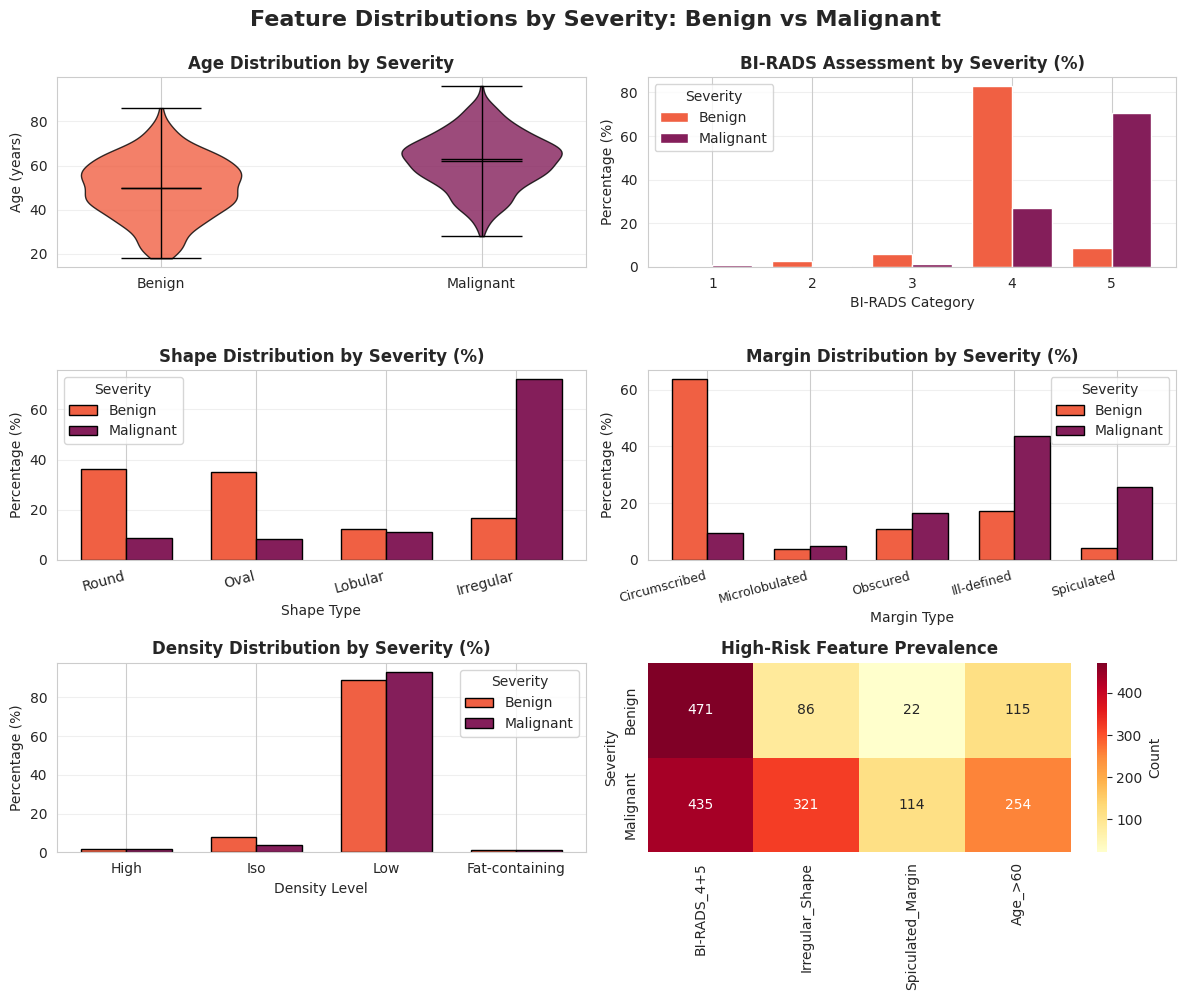

In [13]:

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle('Feature Distributions by Severity: Benign vs Malignant', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Age
ax = axes[0, 0]
violin_parts = ax.violinplot([benign_age, malignant_age], 
                             positions=[0, 1], showmeans=True, showmedians=True)
colors = COLORS_BINARY
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans', 'cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
ax.set_title('Age Distribution by Severity', fontsize=12, fontweight='bold')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Benign', 'Malignant'])
ax.set_ylabel('Age (years)')
ax.grid(axis='y', alpha=0.3)

# 2. BI-RADS
ax = axes[0, 1]
birads_cross = pd.crosstab(df['BI-RADS'], df['Severity'], normalize='columns') * 100
birads_cross.plot(kind='bar', ax=ax, color=COLORS_BINARY, width=0.8)
ax.set_title('BI-RADS Assessment by Severity (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('BI-RADS Category')
ax.set_ylabel('Percentage (%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(['Benign', 'Malignant'], title='Severity')
ax.grid(axis='y', alpha=0.3)

# 3. Shape
ax = axes[1, 0]
shape_cross = pd.crosstab(df['Shape'], df['Severity'], normalize='columns') * 100
x = np.arange(len(shape_cross))
width = 0.35
ax.bar(x - width/2, shape_cross[0], width, label='Benign', 
       color=COLORS_BINARY[0], edgecolor='black')
ax.bar(x + width/2, shape_cross[1], width, label='Malignant', 
       color=COLORS_BINARY[1], edgecolor='black')
ax.set_title('Shape Distribution by Severity (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Shape Type')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels([feature_labels['Shape'][i] for i in shape_cross.index], 
                   rotation=15, ha='right')
ax.legend(title='Severity')
ax.grid(axis='y', alpha=0.3)

# 4. Margin
ax = axes[1, 1]
margin_cross = pd.crosstab(df['Margin'], df['Severity'], normalize='columns') * 100
x = np.arange(len(margin_cross))
ax.bar(x - width/2, margin_cross[0], width, label='Benign', 
       color=COLORS_BINARY[0], edgecolor='black')
ax.bar(x + width/2, margin_cross[1], width, label='Malignant', 
       color=COLORS_BINARY[1], edgecolor='black')
ax.set_title('Margin Distribution by Severity (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Margin Type')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels([feature_labels['Margin'][i] for i in margin_cross.index], 
                   rotation=15, ha='right', fontsize=9)
ax.legend(title='Severity')
ax.grid(axis='y', alpha=0.3)

# 5. Density
ax = axes[2, 0]
density_cross = pd.crosstab(df['Density'], df['Severity'], normalize='columns') * 100
x = np.arange(len(density_cross))
ax.bar(x - width/2, density_cross[0], width, label='Benign', 
       color=COLORS_BINARY[0], edgecolor='black')
ax.bar(x + width/2, density_cross[1], width, label='Malignant', 
       color=COLORS_BINARY[1], edgecolor='black')
ax.set_title('Density Distribution by Severity (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Density Level')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels([feature_labels['Density'][i] for i in density_cross.index])
ax.legend(title='Severity')
ax.grid(axis='y', alpha=0.3)

# 6. Summary heatmap of raw counts
ax = axes[2, 1]
feature_severity_matrix = pd.DataFrame({
    'BI-RADS_4+5': [
        len(df[(df['BI-RADS'] >= 4) & (df['Severity'] == 0)]),
        len(df[(df['BI-RADS'] >= 4) & (df['Severity'] == 1)])
    ],
    'Irregular_Shape': [
        len(df[(df['Shape'] == 4) & (df['Severity'] == 0)]),
        len(df[(df['Shape'] == 4) & (df['Severity'] == 1)])
    ],
    'Spiculated_Margin': [
        len(df[(df['Margin'] == 5) & (df['Severity'] == 0)]),
        len(df[(df['Margin'] == 5) & (df['Severity'] == 1)])
    ],
    'Age_>60': [
        len(df[(df['Age'] > 60) & (df['Severity'] == 0)]),
        len(df[(df['Age'] > 60) & (df['Severity'] == 1)])
    ]
}, index=['Benign', 'Malignant'])

sns.heatmap(feature_severity_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('High-Risk Feature Prevalence', fontsize=12, fontweight='bold')
ax.set_ylabel('Severity')

plt.tight_layout()
plt.show()

#### Multivariate Analysis: Feature Interactions
 
Understanding how features work together is essential for building effective predictive models.


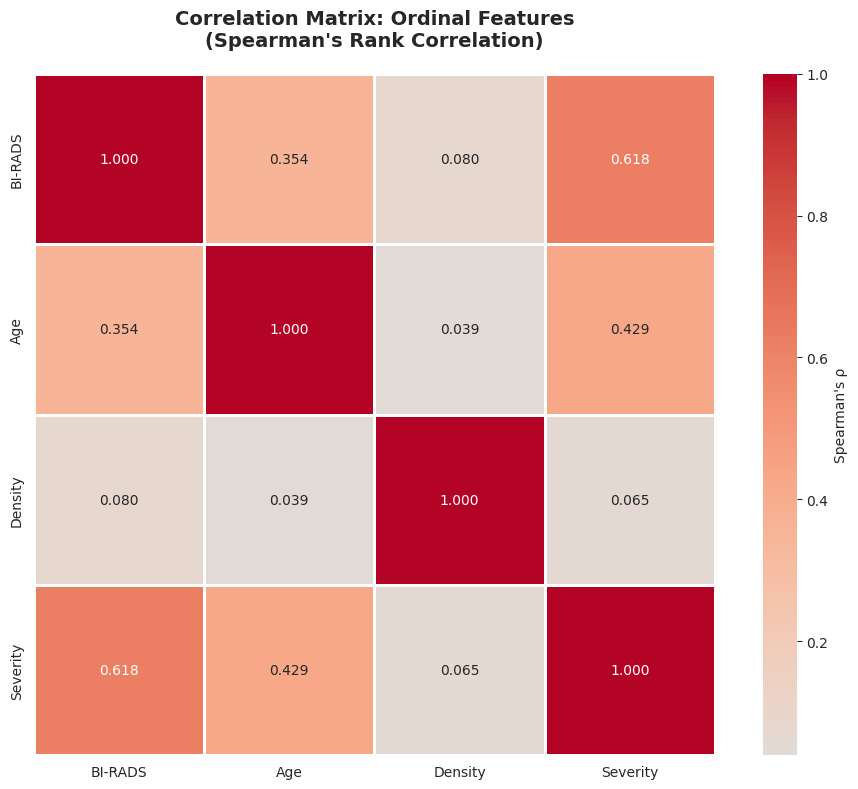



CORRELATIONS WITH SEVERITY


BI-RADS: ρ = 0.618
Age: ρ = 0.429
Density: ρ = 0.065


In [14]:
ordinal_features = ['BI-RADS', 'Age', 'Density', 'Severity']
corr_matrix = df[ordinal_features].corr(method='spearman')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=ax,
            cbar_kws={'label': "Spearman's ρ"})
ax.set_title("Correlation Matrix: Ordinal Features\n(Spearman's Rank Correlation)", 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n")
print("CORRELATIONS WITH SEVERITY")
print("\n")
severity_corr = corr_matrix['Severity'].drop('Severity').sort_values(ascending=False)
for feature, corr_val in severity_corr.items():
    print(f"{feature}: ρ = {corr_val:.3f}")

